In [25]:
import sys
# 1つ上の階層 (project/) を sys.path に追加
sys.path.append("..")

%load_ext autoreload
%autoreload 2

In [1]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task."
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}"
        if entry["input"]
        else ""
    )
    return instruction_text + input_text

In [4]:
model_input = format_input(data[50])
described_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + described_response)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [5]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) *  0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Train data size:", len(train_data))
print("Test data size:", len(test_data))
print("Validation data size:", len(val_data))


Train data size: 935
Test data size: 110
Validation data size: 55


In [ ]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):        
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.encoded_texts[index]

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))


[50256]


In [ ]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device) # 入力リストをテンソルに変換し、ターゲットデバイスに転送
    return inputs_tensor

In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [15]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)  
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor  

In [16]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [17]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None,  device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1: # numelは要素数を返す
            targets[indices[1:]] = ignore_index # 2番目以降の要素をignore_indexに設定

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]            

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)  
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor  

In [18]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():
    # device = torch.device("mps")
print("Device:", device)

Device: cpu


In [45]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [47]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,    
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,    
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,    
    drop_last=False,
    num_workers=num_workers
)

In [48]:
print("Train loader:")
for inputs, targets in train_dataloader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [49]:
from gpt_download import download_and_load_gpt2
from tiny_llm.gpt_model import GPTModel
from tiny_llm.utils import load_weights_into_gpt

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate_emb": 0.0,      
    "drop_rate_attn": 0.0,     
    "drop_rate_shortcut": 0.0, 
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [28]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [50]:
from tiny_llm.utils import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model = model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)

response_text = generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


In [51]:
from tiny_llm.utils import calc_loss_loader, train_model_simple

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_dataloader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_dataloader, model, device, num_batches=5
    )

print("Train loss:", train_loss)
print("Validation loss:", val_loss)

Train loss: 4.0135386943817135
Validation loss: 3.938512849807739


In [52]:
import time

start_time = time.time()
torch.manual_seed(123)  

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.00005,
    weight_decay=0.1,
)  
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer,    
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss: 2.776, Val loss: 2.755
Ep 1 (Step 000005): Train loss: 1.207, Val loss: 1.138
Ep 1 (Step 000010): Train loss: 0.872, Val loss: 0.968
Ep 1 (Step 000015): Train loss: 0.856, Val loss: 0.907
Ep 1 (Step 000020): Train loss: 0.788, Val loss: 0.910
Ep 1 (Step 000025): Train loss: 0.775, Val loss: 0.866
Ep 1 (Step 000030): Train loss: 0.801, Val loss: 0.841
Ep 1 (Step 000035): Train loss: 0.716, Val loss: 0.813
Ep 1 (Step 000040): Train loss: 0.669, Val loss: 0.803
Ep 1 (Step 000045): Train loss: 0.634, Val loss: 0.792
Ep 1 (Step 000050): Train loss: 0.663, Val loss: 0.785
Ep 1 (Step 000055): Train loss: 0.763, Val loss: 0.772
Ep 1 (Step 000060): Train loss: 0.721, Val loss: 0.749
Ep 1 (Step 000065): Train loss: 0.651, Val loss: 0.739
Ep 1 (Step 000070): Train loss: 0.532, Val loss: 0.731
Ep 1 (Step 000075): Train loss: 0.566, Val loss: 0.732
Ep 1 (Step 000080): Train loss: 0.604, Val loss: 0.723
Ep 1 (Step 000085): Train loss: 0.511, Val loss: 0.706
Ep 1 (Step

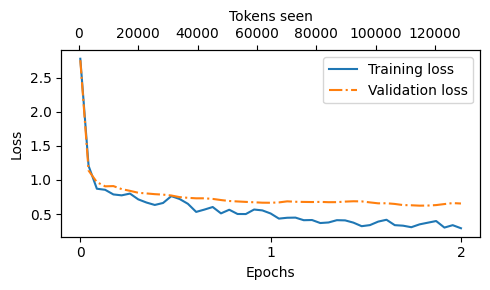

In [53]:
from tiny_llm.utils import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [54]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)    

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256,
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response", "").strip()
    
    print(input_text)
    print(f"\nCorrect response:\n>>{entry['output']}")
    print(f"\nModel response:\n>>{response_text.strip()}")
    print("-" * 80)
    

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>>The car is as fast as lightning.

Model response:
>>:
The car is as fast as a bullet.
--------------------------------------------------------------------------------
Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>>The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>>:
The type of cloud associated with thunderstorms is a cumulus cloud.
--------------------------------------------------------------------------------
Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.



In [55]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)    

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256,
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response", "").strip()

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w", encoding="utf-8") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [05:31<00:00,  3.01s/it]


In [56]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.path"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}") 

Model saved as gpt2-medium355M-sft.path


In [57]:
import psutil

def check_if_runnning(process_name):
    running = False
    for proc in psutil.process_iter(['name']):
        if proc.info['name'] == process_name:
            running = True
            break
    return running

In [59]:
ollama_running = check_if_runnning("ollama")

if not ollama_running:
    raise RuntimeError(
        "Ollama is not running. Please start Ollama before running this code."
    )

print("Ollama running:", check_if_runnning("ollama"))

Ollama running: True


In [68]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode('utf-8')

    request = urllib.request.Request(
        url,
        data=payload,
        method='POST',
    )
    request.add_header('Content-Type', 'application/json')

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode('utf-8')
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


In [70]:
model = "llama3.2"
result = query_model("What do Llamas eat?", model=model)
print(result)

Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and grassy weeds.
2. Hay: High-quality hay, such as timothy hay or alfalfa hay, is a staple in a llama's diet. It provides essential nutrients like fiber, protein, and vitamins.
3. Grains: Llamas may also be fed grains like oats, barley, or corn, but these should not make up more than 10% of their diet.
4. Fruits and vegetables: Fresh fruits and vegetables, such as apples, carrots, and sweet potatoes, can be given to llamas as treats or added to their hay.
5. Browse: Llamas may also eat browse, which includes leaves, twigs, and other vegetation from trees and shrubs.

It's essential to note that llamas have a unique digestive system, with a four-chambered stomach, which allows them to break down and extract nutrients from plant material more efficiently than many other 

In [72]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}`"
        f"and correct output `{entry['output']}`,"
        f"score the model response `{entry['model_response']}`"
        f"on a scale from 0 to 100, where 100 is the best score."
    )
    print("\nDataset response:")
    print(">>>", entry["output"])
    print("\nModel response:")
    print(">>>", entry["model_response"])
    print("\nScore:")
    print(">>>", query_model(prompt, model=model))
    print("-" * 80)


Dataset response:
>>> The car is as fast as lightning.

Model response:
>>> :
The car is as fast as a bullet.

Score:
>>> To score the model response, I would give it a score of 80 out of 100.

Here's why:

* The response "The car is as fast as a bullet" uses a simile to compare the speed of the car to that of a bullet, which is a common and effective way to describe something as being very fast.
* However, the comparison to a bullet might not be the most accurate or evocative choice, as bullets are typically associated with high-velocity projectiles rather than speed. A more fitting simile for describing a car's speed might be one that emphasizes its acceleration or top-end velocity.

A better response would have been "The car is as fast as lightning" (as provided in the correct output), which uses a more vivid and accurate comparison to convey the idea of extremely rapid movement.
--------------------------------------------------------------------------------

Dataset response:
>>>

In [74]:
def generate_model_scores(json_data, json_key, model="llama3.2"):
    scores = []
    for entry in tqdm(json_data, desc="Generating scores"):
        prompt = (
            f"Given the input `{format_input(entry)}`"
            f"and correct output `{entry['output']}`,"
            f"score the model response `{entry[json_key]}`"
            f"on a scale from 0 to 100, where 100 is the best score."
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model=model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Invalid score received: {score}")
            continue
    return scores    

In [75]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores) / len(scores):.2f}\n")

Generating scores:   1%|          | 1/110 [00:02<04:05,  2.25s/it]

Invalid score received: 80

Explanation: The original sentence "The car is very fast" can be rewritten using a simile as "The car is as fast as lightning". This response is close but not perfect because it doesn't use the word "as" which is necessary for a simile. A better response would be "The car is as fast as a bullet."


Generating scores:  10%|█         | 11/110 [00:06<01:02,  1.58it/s]

Invalid score received: 60

Explanation: The correct classification should include both prime and composite numbers. The given input "Prime: 11" is partially correct but misses the prime number "19". It also incorrectly classifies "14" as a composite number, when in fact it's a composite number itself. A more accurate response would be:

 Prime numbers: 11, 19
 Composite numbers: 14


Generating scores:  16%|█▋        | 18/110 [00:09<01:08,  1.35it/s]

Invalid score received: 80

The corrected sentence uses an indefinite pronoun "someone" instead of the definite article "a". The original sentence "Someone left a note." is close but does not use an indefinite pronoun. The corrected response "A note was left by someone." meets the request, but it's still slightly different from the ideal response.


Generating scores:  23%|██▎       | 25/110 [00:12<00:49,  1.72it/s]

Invalid score received: 60

The model response "Están libros" translates to "There are books", which is not correct for the task of translating "library" into Spanish. The correct translation is "biblioteca".


Generating scores:  25%|██▍       | 27/110 [00:14<01:01,  1.35it/s]

Invalid score received: 60

The model's response is partially correct, but it doesn't provide the actual translation. A more accurate response would be "The Russian translation of 'Hello' is 'Привет' (Privet)."


Generating scores:  40%|████      | 44/110 [00:18<00:16,  3.98it/s]

Invalid score received: Score: 20


Generating scores:  44%|████▎     | 48/110 [00:19<00:22,  2.76it/s]

Invalid score received: I would categorize "What a beautiful day!" as an exclamation.

Score: 90


Generating scores:  45%|████▌     | 50/110 [00:20<00:23,  2.53it/s]

Invalid score received: The synonym for "begin" is "commence".

Score: 100


Generating scores:  47%|████▋     | 52/110 [00:22<00:48,  1.20it/s]

Invalid score received: 80

The model response "Could you help me tomorrow?" correctly transforms the input sentence into a question using "could." It also adds the correct verb conjugation ("help") and maintains the original meaning of the sentence. The only minor improvement could be adding an apostrophe to "you're" (you are), but that's not necessary in this case.


Generating scores:  65%|██████▍   | 71/110 [00:27<00:13,  2.80it/s]

Invalid score received: The corrected sentence is: "I prefer homemade cookies to store bought."

Score: 80


Generating scores:  70%|███████   | 77/110 [00:30<00:27,  1.21it/s]

Invalid score received: I would give this model response a score of 20.

The reason for this low score is that the model's response does not create a simile with the word "as cold as". Instead, it provides a factual piece of information about temperature. A good response should use the given phrase to create a comparison between two things, like in the correct output: "Her hands were as cold as ice."


Generating scores:  71%|███████   | 78/110 [00:31<00:25,  1.27it/s]

Invalid score received: Swim: Verb
Beautiful: Adjective
Quickly: Adverb

Score: 100


Generating scores:  72%|███████▏  | 79/110 [00:33<00:34,  1.10s/it]

Invalid score received: I would give this response a score of 60.

Here's why:

- The response provides the correct formula for calculating density (mass/volume).
- It includes the units in the answer.
- However, it does not provide the actual calculation or the result of the calculation, which is necessary to determine the density of the object.


Generating scores:  76%|███████▋  | 84/110 [00:35<00:20,  1.26it/s]

Invalid score received: 80

The input sentence "He was as cool as a cucumber" uses the clichéd expression "as cool as a cucumber," which means being calm and composed. The corrected response "He remained very calm" avoids this cliché and conveys the same idea in a more original way.


Generating scores:  85%|████████▍ | 93/110 [00:38<00:05,  3.27it/s]

Invalid score received: Score: 0


Generating scores:  95%|█████████▍| 104/110 [00:43<00:05,  1.11it/s]

Invalid score received: The correct translation of "see you later" into Spanish is indeed "hasta luego".

As for the model response "Están leyendo see you later.", I would score it a 0 out of 100.

This response is incorrect because:

* It doesn't translate the phrase "see you later", but rather states that people are reading the phrase.
* The word "leyendo" means "reading", not translating.

Therefore, the score is 0.


Generating scores:  98%|█████████▊| 108/110 [00:45<00:01,  1.74it/s]

Invalid score received: I would classify the sentence "Please open the door." as imperative because it is a command or request.

Score: 90


Generating scores: 100%|██████████| 110/110 [00:45<00:00,  2.42it/s]

Number of scores: 93 of 110
Average score: 49.68

